In [1]:
from skimage.io import imread, imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/version1')
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from data import trainGenerator, validationGenerator, makePredictions
from model import unet
import gc
from evaluate import my_iou_metric, iou_metric
from keras.preprocessing.image import load_img, save_img
from keras.models import load_model
from keras.preprocessing.image import img_to_array

gc.enable()

Using TensorFlow backend.


# 1. Define Input Parameters

In [ ]:
orig_data_dir = 'U_NET/validation'
dest_data_dir = 'data/test/'

orig_mask_dir = 'masks'
dest_mask_dir = 'label'

orig_image_dir = 'images'
dest_image_dir = 'img'

# loop throught all the image folders
data_folders = os.listdir(orig_data_dir)
for folder_name in tqdm(data_folders):
    folder = os.path.join(orig_data_dir, folder_name)
    
    # get image
    image = os.listdir(os.path.join(folder, orig_image_dir))
    image = imread(os.path.join(folder, orig_image_dir, image[0]))
    
    # Now we take all masks associated with that image and combine them into one single mask
    masks = os.listdir(os.path.join(folder, orig_mask_dir))
    # create 0 values mask
    new_mask = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.bool)
    for mask in masks:
        mask_ = np.expand_dims(imread(os.path.join(folder, orig_mask_dir, mask)), axis=-1)
        #plt.imshow(mask_[:,:,0])
        #plt.show()
        new_mask = np.maximum(new_mask, mask_)
    #plt.imshow(new_mask[:,:,0])
    #plt.show()
    #plt.imshow(image)
    #plt.show()
    imsave(os.path.join(dest_data_dir, dest_mask_dir, folder_name+'.png'), new_mask)
    imsave(os.path.join(dest_data_dir, dest_image_dir, folder_name+'.png'), image)

# 2. Load Data

In [3]:
data_gen_train = dict(rescale=1./255
                     #rotation_range=0.2,
                     #width_shift_range=0.05,
                     #height_shift_range=0.05,
                     #shear_range=0.05,
                     #zoom_range=0.05,
                     #horizontal_flip=True,
                     #fill_mode='nearest'
                     )

data_gen_test = dict(rescale=1./255)

train_gen = trainGenerator(16, 
                           'data/train', 
                           'img', 
                           'label', 
                           data_gen_train,
                           image_color_mode='rgb',
                           target_size=(128,128))

test_gen = validationGenerator(8, 
                               'data/val', 
                               'img', 
                               'label', 
                               data_gen_test, 
                               image_color_mode='rgb',
                               target_size=(128,128))

# 3. Setup the Model

In [4]:
model = unet(input_size=(128,128,3))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
__________________________________________________________________________________________________
Layer (type

/content/drive/My Drive/Colab Notebooks/version1/model.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input=inputs, output=conv10)


# 4. Define other model parameters

In [5]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta = 0,
                               patience=5, 
                               verbose=1,
                               restore_best_weights=True)

model_checkpoint = ModelCheckpoint('unet.h5', 
                                   monitor='val_loss', 
                                   mode='min',
                                   verbose=1, 
                                   save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor = 0.2,
                              min_delta=0.0001,
                              patience=3,
                              verbose=1)

# 5. Fitting the model

In [6]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=610//16, 
                              epochs=25,
                              validation_data=test_gen,
                              validation_steps=60//8,
                              callbacks=[model_checkpoint, early_stopping, reduce_lr])




Epoch 1/25
Found 60 images belonging to 1 classes.
Found 610 images belonging to 1 classes.
Found 60 images belonging to 1 classes.
Found 610 images belonging to 1 classes.





38/38 [==============================] - 31s 812ms/step - loss: 0.4532 - acc: 0.8517 - my_iou_metric: 0.0178 - val_loss: 0.1988 - val_acc: 0.9058 - val_my_iou_metric: 0.1600

Epoch 00001: val_loss improved from inf to 0.19878, saving model to unet.h5
Epoch 2/25
38/38 [==============================] - 22s 586ms/step - loss: 0.1556 - acc: 0.9326 - my_iou_metric: 0.2561 - val_loss: 0.1318 - val_acc: 0.9470 - val_my_iou_metric: 0.3665

Epoch 00002: val_loss improved from 0.19878 to 0.13177, saving model to unet.h5
Epoch 3/25
38/38 [==============================] - 18s 467ms/step - loss: 0.1099 - acc: 0.9579 - my_iou_metric: 0.4059 - val_loss: 0.0879 - val_acc: 0.9659 - val_my_iou_metric: 0.5203

Epoch 00003: val_loss improved from 0.13177 to 0.08794, saving model to unet.h5
Epoch 4/25
38/38 [==================

# 6. Predictions

In [2]:
# add the custom metric object to load the model
custom_object = {'my_iou_metric': my_iou_metric}

# images dir
test_images_dir = 'data/val/img'
# output dir
test_output_dir = 'data/val/prediction'

# make predictions
makePredictions(test_output_dir, test_images_dir, 'unet.h5', custom_object)    

100%|██████████| 60/60 [00:04<00:00, 13.60it/s]


# 6. Evaluating Model

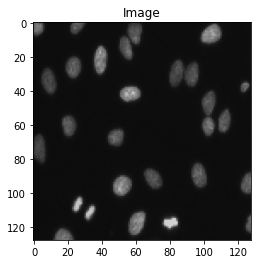

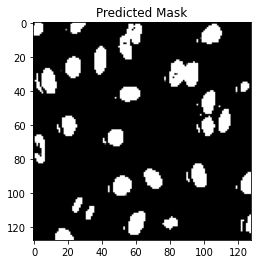

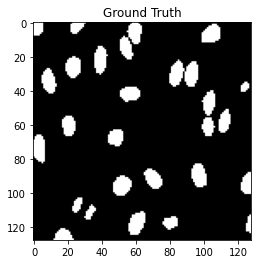

Thresh	TP	FP	FN	Prec.
0.500	26	16	0	0.619
0.550	26	16	0	0.619
0.600	26	16	0	0.619
0.650	26	16	0	0.619
0.700	25	17	1	0.581
0.750	24	18	2	0.545
0.800	24	18	2	0.545
0.850	22	20	4	0.478
0.900	19	23	7	0.388
0.950	10	32	16	0.172
AP	-	-	-	0.519


0.5186924680646258

In [14]:
# define custom object
custom_object = {'my_iou_metric': my_iou_metric}
# load model
model = load_model('unet.h5', custom_objects=custom_object)

# images dir
test_images_dir = 'data/val/img'
# labels dir
test_labels_dir = 'data/val/label'

# get prediction and ground truth values
test_images = os.listdir(test_images_dir)
test_image = test_images[np.random.randint(0, len(test_images), 1)[0]]
x_test = load_img(os.path.join(test_images_dir, test_image), target_size=(128,128))
plt.title('Image')
plt.imshow(x_test)
plt.show()

input_arr = img_to_array(x_test)
input_arr = np.array([input_arr])  # Convert single image to a batch.
prediction = model.predict(input_arr)
plt.title('Predicted Mask')
plt.imshow(prediction[0,:,:,0], cmap='gray')
plt.show()

gt = load_img(os.path.join(test_labels_dir, test_image), color_mode='grayscale', target_size=(128,128))
plt.title('Ground Truth')
plt.imshow(gt, cmap='gray')
plt.show()
gt = img_to_array(gt)

prediction_scaled = prediction[0,:,:,:]
gt_scaled = gt/255

iou_metric(gt_scaled, prediction_scaled, print_table=True)